In [1]:
import numpy
numpy.__version__



'1.26.4'

In [3]:
save_path_videos = '/kaggle/input/eng-lingual/dataset_Videos.npy'
save_path_labels = '/kaggle/input/eng-lingual/dataset_labels.npy'

In [4]:
import numpy as np

videos = np.load(save_path_videos)
labels = np.load(save_path_labels)

In [5]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape) 
print("Labels shape:", labels.shape)

Videos shape: (4050, 22, 80, 112, 1)
Labels shape: (4050,)


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode the labels into numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# One-hot encode the labels
labels_onehot = to_categorical(labels_encoded)

# Display the mapping
print("✅ Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

print("✅ Labels encoded and one-hot encoded.")


✅ Label encoding mapping:
0 → a
1 → bye
2 → can
3 → cat
4 → demo
5 → dog
6 → hello
7 → here
8 → is
9 → lips
10 → my
11 → read
12 → you
✅ Labels encoded and one-hot encoded.


In [7]:
label_dict = {0:"a", 1: "bye", 2:"can", 3:"cat", 4:"demo", 5:"dog", 6: "hello", 7:"here", 8:"is", 9:"lips", 10:"my", 11:"read", 12:"you"}

In [8]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    videos, labels_onehot, test_size=0.2, random_state=42, stratify=labels_encoded
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


Training set: (3240, 22, 80, 112, 1), (3240, 13)
Validation set: (810, 22, 80, 112, 1), (810, 13)


In [9]:
del videos
del labels
del labels_encoded
del labels_onehot

In [10]:
import gc
gc.collect()
!cat /proc/meminfo | grep Mem


MemTotal:       32873392 kB
MemFree:        16501344 kB
MemAvailable:   27513940 kB


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
from tensorflow.keras.optimizers import Adam

# =============================================================================
# 1. Memory-Efficient Patch Embedding
# =============================================================================

class MemoryEfficientPatchEmbedding(layers.Layer):
    """Memory-efficient patch embedding for lip sequences"""

    def __init__(self, patch_size, embed_dim, **kwargs):
        super(MemoryEfficientPatchEmbedding, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        # Use Conv2D instead of Dense for better memory efficiency
        self.projection = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)

    def call(self, images):
        # Input shape: (batch, sequence, height, width, channels)
        batch_size = tf.shape(images)[0]
        sequence_length = tf.shape(images)[1]
        
        # Reshape to process all frames at once
        # (batch * sequence, height, width, channels)
        images_reshaped = tf.reshape(images, [-1, tf.shape(images)[2], tf.shape(images)[3], tf.shape(images)[4]])
        
        # Apply convolution to create patches
        patches = self.projection(images_reshaped)
        
        # Flatten spatial dimensions
        # (batch * sequence, num_patches_h, num_patches_w, embed_dim)
        patch_shape = tf.shape(patches)
        num_patches = patch_shape[1] * patch_shape[2]
        
        # Reshape to (batch * sequence, num_patches, embed_dim)
        patches_flat = tf.reshape(patches, [-1, num_patches, self.embed_dim])
        
        # Reshape back to include sequence dimension
        # (batch, sequence * num_patches, embed_dim)
        total_patches = sequence_length * num_patches
        embeddings = tf.reshape(patches_flat, [batch_size, total_patches, self.embed_dim])
        
        return embeddings


# =============================================================================
# 6. Model Creation and Compilation
# =============================================================================

print("=== Creating Memory-Optimized ViT Models for Lip Reading ===\n")

# Model 1: Lightweight ViT
print("1. Creating Lightweight ViT...")
lightweight_vit = create_lightweight_vit_lips(
    input_shape=(22, 80, 112, 1),
    num_classes=13,
    patch_size=16,
    embed_dim=128,
    num_heads=4,
    num_transformer_blocks=2
)

lightweight_vit.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Lightweight ViT compiled successfully!")
print(f"Parameters: {lightweight_vit.count_params():,}")
print()


# =============================================================================
# Model Summaries
# =============================================================================

print("=== Model Summaries ===\n")

print("1. LIGHTWEIGHT ViT SUMMARY:")
print("-" * 50)
lightweight_vit.summary()
print()



=== Creating Memory-Optimized ViT Models for Lip Reading ===

1. Creating Lightweight ViT...
✓ Lightweight ViT compiled successfully!
Parameters: 306,957

=== Model Summaries ===

1. LIGHTWEIGHT ViT SUMMARY:
--------------------------------------------------


Model: "Lightweight_ViT_Lips"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 22, 80, 112, 1)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ memory_efficient_patch_embedding_2   │ (None, 770, 128)            │          32,896 │
│ (MemoryEfficientPatchEmbedding)      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_4 (Add)                          │ (None, 770, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lightweight_transformer_block_4      │ (None, 770, 128)            │         132,480 │
│ (LightweightTransformerBlock)        │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lightweight_transformer_block_5      │ (None, 770, 128)            │         132,480 │
│ (LightweightTransformerBlock)        │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 13)                  │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 306,957 (1.17 MB)

 Trainable params: 306,957 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = lightweight_vit.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=50,
    shuffle=True
)


Epoch 1/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.0696 - loss: 2.6518 - val_accuracy: 0.0802 - val_loss: 2.5750
Epoch 2/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.0761 - loss: 2.5806 - val_accuracy: 0.0765 - val_loss: 2.5682
Epoch 3/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.0719 - loss: 2.5758 - val_accuracy: 0.0741 - val_loss: 2.5666
Epoch 4/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.0800 - loss: 2.5784 - val_accuracy: 0.0802 - val_loss: 2.5653
Epoch 5/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.0831 - loss: 2.5721 - val_accuracy: 0.0926 - val_loss: 2.5643
Epoch 6/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.0749 - loss: 2.5745 - val_accuracy: 0.0827 - val_loss: 2.5654
Epoch 7/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.0740 - loss: 2.5708 - val_accuracy: 0.0741 - val_loss: 2.5648
Epoch 8/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.0697 - loss: 2.5680 - 

In [21]:
def evaluate_model(model, name="Model"):
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} - Validation Accuracy: {acc:.4f}, Loss: {loss:.4f}")

evaluate_model(lightweight_vit, "Vision Transformer ")



Vision Transformer  - Validation Accuracy: 0.0815, Loss: 2.5642


In [23]:
y_pred_prob = lightweight_vit.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step


In [24]:
from prettytable import PrettyTable
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Convert y_pred to one-hot encoded format to match y_val
y_pred_onehot = to_categorical(y_pred, num_classes=y_val.shape[1])

# Generate classification report
report = classification_report(y_val, y_pred_onehot, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+-------+-----------+--------+----------+---------+
| Class | Precision | Recall | F1-Score | Support |
+-------+-----------+--------+----------+---------+
|   a   |    0.0    |  0.0   |   0.0    |    64   |
|  bye  |    0.0    |  0.0   |   0.0    |    62   |
|  can  |    0.0    |  0.0   |   0.0    |    61   |
|  cat  |    0.0    |  0.0   |   0.0    |    59   |
|  demo |    0.0    |  0.0   |   0.0    |    62   |
|  dog  |    0.0    |  0.0   |   0.0    |    60   |
| hello |    0.0    |  0.0   |   0.0    |    57   |
|  here |    0.08   |  1.0   |   0.15   |    66   |
|   is  |    0.0    |  0.0   |   0.0    |    65   |
|  lips |    0.0    |  0.0   |   0.0    |    64   |
|   my  |    0.0    |  0.0   |   0.0    |    64   |
|  read |    0.0    |  0.0   |   0.0    |    65   |
|  you  |    0.0    |  0.0   |   0.0    |    61   |
+-------+-----------+--------+----------+---------+


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


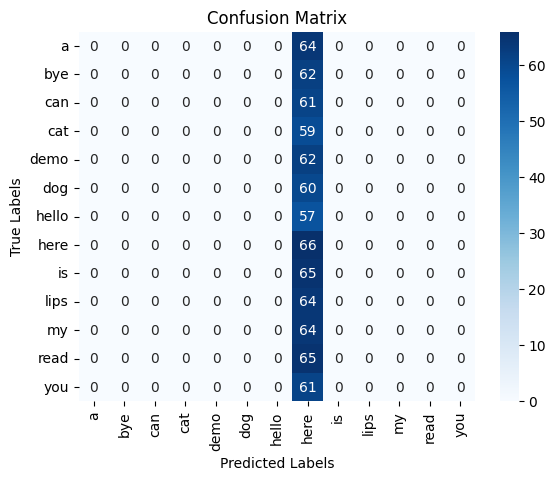

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Convert y_val to multiclass format
y_val_multiclass = np.argmax(y_val, axis=1)  # Convert one-hot to class indices

# Now generate the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(y_val_multiclass, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

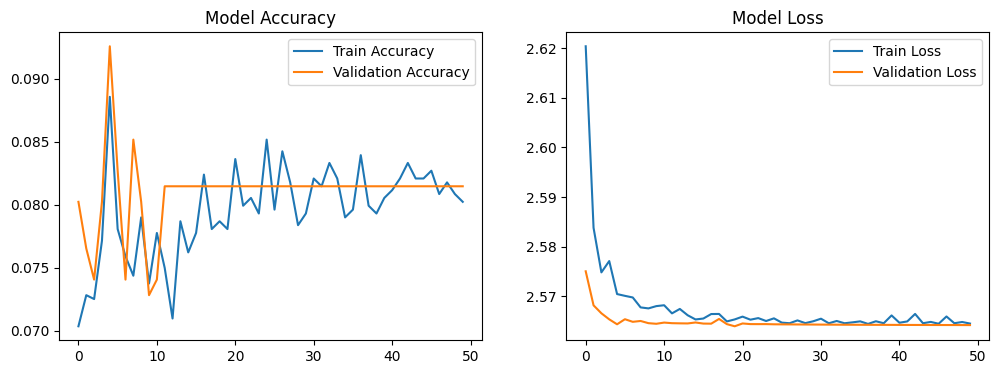

In [26]:
import matplotlib.pyplot as plt
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_training_history(history)


In [28]:
# Save the trained model
lightweight_vit.save("/kaggle/working/vit.h5")
print("✅ Model saved.")


✅ Model saved.
